In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RandomizedSearchCV
from get_metrics1 import get_metrics_classification
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import shap
from get_metrics1 import get_metrics_classification
from sklearn.inspection import permutation_importance
from SupFunctions import barplot_group, barplot_balance, check_overfitting_classification, check_overfitting_multiclass, scale_pos_weight_calc
from sklearn.inspection import permutation_importance
from SupFunctions import barplot_group, barplot_balance, check_overfitting_classification, check_overfitting_multiclass, scale_pos_weight_calc
import warnings
from warnings import simplefilter
warnings.filterwarnings("ignore")
simplefilter("ignore", category=RuntimeWarning)

RAND = 10
N_FOLD = 5

In [2]:
df_dota = pd.read_csv('df_dota.csv')

In [3]:
df_metrics = pd.read_csv('models_metrics_final.csv')

In [4]:
meta_X = pd.read_csv('meta_X_final.csv')

In [5]:
meta_X_test = pd.read_csv('meta_X_test_final.csv')

In [11]:
meta_X = meta_X.set_index('index')

In [12]:
meta_X_test = meta_X_test.set_index('index')

In [6]:
df_dota.head()

,match_id,radiant_win,duration,Support,Initiator,Pusher,Escape,Nuker,Carry,Durable,Disabler,early_game_gold_adv,early_game_xp_adv,radiant_bottom_tier_1,radiant_middle_tier_1,radiant_top_tier_1,dire_bottom_tier_1,dire_middle_tier_1,dire_top_tier_1
0,7967435715,1,35,3,2,1,3,4,3,2,5,3844,1721,0,0,0,0,0,0
1,7967438032,1,41,2,4,2,1,5,3,3,5,1238,484,0,0,0,0,0,0
2,7967459521,0,28,2,2,2,3,2,4,1,3,-380,29,0,0,1,1,0,0
3,7967484383,0,26,0,3,1,4,4,1,2,3,-2797,-2048,0,0,0,0,0,0
4,7967484981,0,27,2,3,2,2,5,3,4,5,-1454,-2202,0,0,0,0,1,0


In [7]:
df_metrics

,model,Accuracy,ROC_AUC,Logloss,Precision,Recall,f1
0,Random Forest baseline Holdout,0.723859,0.819073,0.499654,0.739712,0.686724,0.712234
1,Catboost baseline Holdout,0.721008,0.823945,0.494296,0.737603,0.681948,0.708685
2,LightGBM baseline Holdout,0.712928,0.820036,0.497216,0.725790,0.680038,0.702170
3,Catboost best Holdout,0.716255,0.824472,0.492006,0.732919,0.676218,0.703428
4,Catboost best Holdout,0.718156,0.821629,0.498345,0.732582,0.682904,0.706871
5,LightGBM best Holdout,0.714829,0.821686,0.494060,0.729231,0.679083,0.703264


In [13]:
meta_X.head()

,rf_01,catboost_01,lgbm_01,catboost_best_01,rf_best,lgbm_best
index,,,,,,
6309,0.94,0.960736,0.974764,0.968364,0.936939,0.936311
218,0.20,0.283706,0.156880,0.305978,0.293144,0.258460
3270,0.63,0.616160,0.588529,0.616941,0.640958,0.601820
2101,0.31,0.360419,0.370514,0.383596,0.369312,0.317081
2918,0.56,0.506338,0.427501,0.443900,0.490041,0.446367


In [14]:
meta_X_test.head()

,rf_01,catboost_01,lgbm_01,catboost_best_01,rf_best,lgbm_best
index,,,,,,
2004,0.316,0.397284,0.380385,0.402477,0.378933,0.382387
5616,0.044,0.065483,0.048569,0.061619,0.051262,0.056927
2635,0.214,0.338947,0.179918,0.321341,0.312210,0.334825
7907,0.020,0.039754,0.023750,0.030149,0.039381,0.039585
1667,0.946,0.947815,0.994234,0.968427,0.919239,0.984545


In [28]:
X = df_dota.drop(['radiant_win', 'match_id'], axis=1)
y = df_dota['radiant_win']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y, 
                                                    random_state=RAND)

In [29]:
final_clf = LogisticRegression(random_state=RAND)
final_clf.fit(meta_X, y_train)

LogisticRegression(random_state=10)

In [30]:
y_pred_final = final_clf.predict(meta_X_test)
y_proba_final = final_clf.predict_proba(meta_X_test)

y_proba_train = final_clf.predict_proba(meta_X)

In [32]:
check_overfitting_classification(final_clf,
                  meta_X,
                  y_train,
                  meta_X_test,
                  y_test)

ROC-AUC train: 0.833
ROC-AUC test: 0.825
delta = 1.1 %


(0.8334194173851721, 0.8245814730378005, 1.0718097163658282)

In [35]:
df_metrics = pd.concat([df_metrics, get_metrics_classification(y_test, y_pred_final, y_proba_final, 'Stacking LogisticRegression')], axis=0)
df_metrics

,model,Accuracy,ROC_AUC,Logloss,Precision,Recall,f1
0,Random Forest baseline Holdout,0.723859,0.819073,0.499654,0.739712,0.686724,0.712234
1,Catboost baseline Holdout,0.721008,0.823945,0.494296,0.737603,0.681948,0.708685
2,LightGBM baseline Holdout,0.712928,0.820036,0.497216,0.725790,0.680038,0.702170
3,Catboost best Holdout,0.716255,0.824472,0.492006,0.732919,0.676218,0.703428
4,Catboost best Holdout,0.718156,0.821629,0.498345,0.732582,0.682904,0.706871
5,LightGBM best Holdout,0.714829,0.821686,0.494060,0.729231,0.679083,0.703264
0,Stacking LogisticRegression,0.717205,0.824581,0.500615,0.735417,0.674308,0.703538


Радикальных улучшений не видно по метрикам, но переобучение значительно снизилось до 1.1% (в моделях оно варировалось от 4% до 9%).

In [46]:
def plot_confusion_matrix(y_true, y_pred, ax=None):
    """Визуализация ConfusionMatrix"""
    labels = list(set(y_pred))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
    if ax:
        disp.plot(ax=ax)
    else:
        disp.plot()

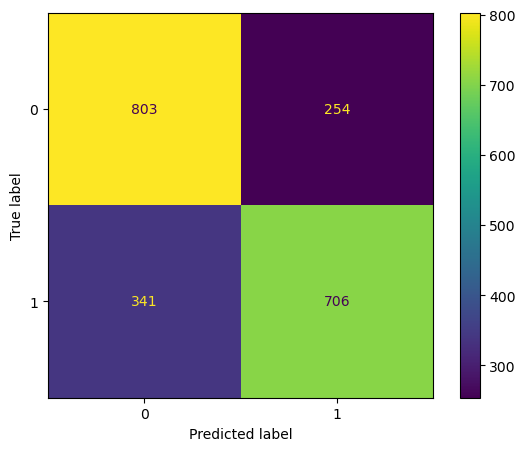

In [50]:
# Создаем фигуру и оси
fig, ax = plt.subplots(figsize=(7, 5))

# Визуализируем матрицу ошибок
plot_confusion_matrix(y_true=y_test, y_pred=y_pred_final, ax=ax)
plt.show()

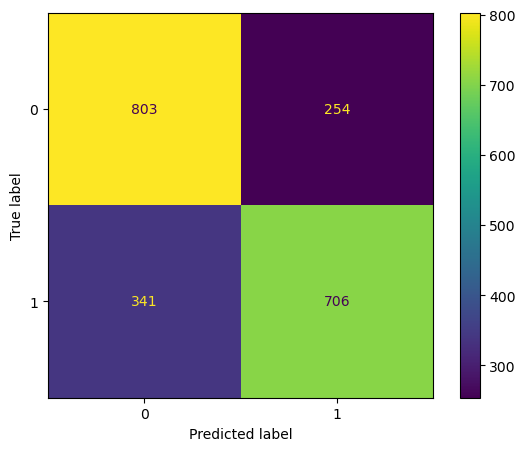

In [49]:
def plot_confusion_matrix(y_true, y_pred, ax=None):
    """Визуализация ConfusionMatrix"""
    labels = list(set(y_pred))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
    if ax:
        disp.plot(ax=ax)
    else:
        disp.plot()

# Создаем фигуру и оси
fig, ax = plt.subplots(figsize=(7, 5))

# Визуализируем матрицу ошибок
plot_confusion_matrix(y_true=y_test, y_pred=y_pred_final, ax=ax)
plt.show()